# Predicting house sales prices using Machine Learning

The goal of this project is to predict the sale price of houses.

## 1. Problem Definition

 > How well can we predict the future sale price of a house, given an array of features collected from previous sales and the price this houses have sell for?
 
## 2. Data

The data is downloaded from the kaggle "House Prices - Advanced Regression Techniques" competition.
Source:https://www.kaggle.com/competitions/house-prices-advanced-regression-techniques/overview

There ara 2 main datasets:

* Train.csv - is the training set
* Test.csv - is the test set

## 3. Evaluation

The evaluation metric for this competition is the RMSE (root mean squared error) over the logarithm of the actual sale price and the logarithm of the predicted one (This equates to say the RMSLE). The goal for this project (as with most regression evaluation metrics) will be to minimize RMSE.

For more info about the evaluation of the project visit:
https://www.kaggle.com/competitions/house-prices-advanced-regression-techniques/overview/evaluation

## 4. Features

Kaggle provides an extensive amount of metadata, but given the lenght of the data description of the features a link to the competition page will be given to not make this section too lenghty:

Reference: https://www.kaggle.com/competitions/house-prices-advanced-regression-techniques/data

In there refer to the data fields and data description section for more info.

In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn

In [3]:
# Import the training sets
pwd = os.getcwd()
df = pd.read_csv(pwd + r'\data\train.csv')

### Taking a brief look at the data

A quick EDA will allow a better understanding of the data and reveal any requierement for further cleaning or formating.

In [4]:
df.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

In [6]:
df.isna().sum()

Id                 0
MSSubClass         0
MSZoning           0
LotFrontage      259
LotArea            0
                ... 
MoSold             0
YrSold             0
SaleType           0
SaleCondition      0
SalePrice          0
Length: 81, dtype: int64

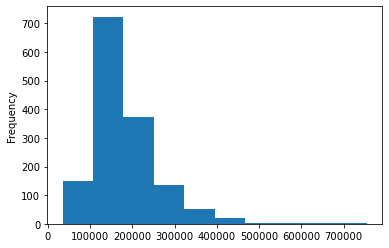

In [7]:
# Sale Price is the target for the prediction, let's take a look at the data distribution
df.SalePrice.plot.hist();

### As an initial aproach the data will be treated as a time series problem
### Sort DataFrame by saledate

In [8]:
# Sort DataFrame in date order
df.sort_values(['YrSold', 'MoSold'], inplace=True, ascending=[True,True])
df.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
141,142,20,RL,78.0,11645,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,1,2006,WD,Normal,260000
169,170,20,RL,NaN,16669,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,1,2006,WD,Normal,228000
302,303,20,RL,118.0,13704,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,1,2006,WD,Normal,205000
370,371,60,RL,NaN,8121,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,1,2006,WD,Normal,172400
411,412,190,RL,100.0,34650,Pave,NaN,Reg,Bnk,AllPub,...,0,NaN,NaN,NaN,0,1,2006,WD,Normal,145000


### Copying the dataframe

In [9]:
df_tmp = df.copy()

## 5. Modelling

Once the EDA has been performed to satisfactory degree a model driven EDA can be performed.

In [10]:
from sklearn.ensemble import RandomForestRegressor

### Converting strings to categories

To  fit the model all the features data type must be numeric, this is achieved by converting them to categories.

In [11]:
# Columns which contain strings
for label, content in df_tmp.items():
    if pd.api.types.is_string_dtype(content):
        print(label)

MSZoning
Street
Alley
LotShape
LandContour
Utilities
LotConfig
LandSlope
Neighborhood
Condition1
Condition2
BldgType
HouseStyle
RoofStyle
RoofMatl
Exterior1st
Exterior2nd
MasVnrType
ExterQual
ExterCond
Foundation
BsmtQual
BsmtCond
BsmtExposure
BsmtFinType1
BsmtFinType2
Heating
HeatingQC
CentralAir
Electrical
KitchenQual
Functional
FireplaceQu
GarageType
GarageFinish
GarageQual
GarageCond
PavedDrive
PoolQC
Fence
MiscFeature
SaleType
SaleCondition


In [12]:
# Turn the string types into categorical values
for label, content in df_tmp.items():
    if pd.api.types.is_string_dtype(content):
        df_tmp[label] = content.astype('category').cat.as_ordered()

In [13]:
# Results
df_tmp.dtypes

Id                  int64
MSSubClass          int64
MSZoning         category
LotFrontage       float64
LotArea             int64
                   ...   
MoSold              int64
YrSold              int64
SaleType         category
SaleCondition    category
SalePrice           int64
Length: 81, dtype: object

In [14]:
df_tmp.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
141,142,20,RL,78.0,11645,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,1,2006,WD,Normal,260000
169,170,20,RL,NaN,16669,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,1,2006,WD,Normal,228000
302,303,20,RL,118.0,13704,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,1,2006,WD,Normal,205000
370,371,60,RL,NaN,8121,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,1,2006,WD,Normal,172400
411,412,190,RL,100.0,34650,Pave,NaN,Reg,Bnk,AllPub,...,0,NaN,NaN,NaN,0,1,2006,WD,Normal,145000


### Saving Preprocessed data

In [15]:
# Exporting tmp df
df_tmp.to_csv(r'C:\Users\josep\Desktop\Data Science Group\Jose_data_analysis\Machine learning\Predicting_House_sales_prices\data\train_tmp.csv',
             index=False)

In [16]:
# Import preprocessed data
df_tmp = pd.read_csv(r'C:\Users\josep\Desktop\Data Science Group\Jose_data_analysis\Machine learning\Predicting_House_sales_prices\data\train_tmp.csv',)

In [17]:
df_tmp

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,142,20,RL,78.0,11645,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,1,2006,WD,Normal,260000
1,170,20,RL,NaN,16669,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,1,2006,WD,Normal,228000
2,303,20,RL,118.0,13704,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,1,2006,WD,Normal,205000
3,371,60,RL,NaN,8121,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,1,2006,WD,Normal,172400
4,412,190,RL,100.0,34650,Pave,NaN,Reg,Bnk,AllPub,...,0,NaN,NaN,NaN,0,1,2006,WD,Normal,145000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,420,20,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,7,2010,WD,Normal,142000
1456,706,190,RM,70.0,5600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,Othr,3500,7,2010,WD,Normal,55000
1457,1145,190,RL,60.0,12180,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,MnPrv,NaN,0,7,2010,WD,Normal,80000
1458,1161,160,RL,24.0,2280,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,7,2010,WD,Normal,146000


### Splitting the data into train/validation sets

In [18]:
df_tmp.YrSold.unique()

array([2006, 2007, 2008, 2009, 2010], dtype=int64)

The set present us with data for 5 years, as the approach to the problem is of a time series the first 4 years (2006, 2007, 2008, 2009) will be used as the training dataset and the last year (2010) as the validation dataset.

In [19]:
df_train = df_tmp[df_tmp.YrSold != 2010]
df_val = df_tmp[df_tmp.YrSold == 2010]

len(df_train), len(df_val)

(1285, 175)

## Filling missing values
### Filling numerical missing values

In [20]:
# Checking for missing values in the training dataset
df_train.isna().sum()

Id                 0
MSSubClass         0
MSZoning           0
LotFrontage      227
LotArea            0
                ... 
MoSold             0
YrSold             0
SaleType           0
SaleCondition      0
SalePrice          0
Length: 81, dtype: int64

In [21]:
# Checking for missing values in the validation dataset
df_val.isna().sum()

Id                0
MSSubClass        0
MSZoning          0
LotFrontage      32
LotArea           0
                 ..
MoSold            0
YrSold            0
SaleType          0
SaleCondition     0
SalePrice         0
Length: 81, dtype: int64

In [22]:
# Checking for numeric columns in the datasets
def numeric_col_checker(dataset):
    for label, content in dataset.items():
        if pd.api.types.is_numeric_dtype(content):
            print(label)

In [23]:
# Training dataset numeric columns - as the format is the same for both validation and training data the result
# applies to both datasets.
numeric_col_checker(df_train)

Id
MSSubClass
LotFrontage
LotArea
OverallQual
OverallCond
YearBuilt
YearRemodAdd
MasVnrArea
BsmtFinSF1
BsmtFinSF2
BsmtUnfSF
TotalBsmtSF
1stFlrSF
2ndFlrSF
LowQualFinSF
GrLivArea
BsmtFullBath
BsmtHalfBath
FullBath
HalfBath
BedroomAbvGr
KitchenAbvGr
TotRmsAbvGrd
Fireplaces
GarageYrBlt
GarageCars
GarageArea
WoodDeckSF
OpenPorchSF
EnclosedPorch
3SsnPorch
ScreenPorch
PoolArea
MiscVal
MoSold
YrSold
SalePrice


In [24]:
# Numeric columns with null values
def num_col_null_checker(dataset):
    for label, content in dataset.items():
        if pd.api.types.is_numeric_dtype(content) and pd.isnull(content).sum():
            print(label)

In [25]:
# Checking for null values in the training dataset numeric colunmns
num_col_null_checker(df_train)

LotFrontage
MasVnrArea
GarageYrBlt


In [26]:
# Checking for null values in the validation dataset numeric colunmns
num_col_null_checker(df_val)

LotFrontage
MasVnrArea
GarageYrBlt


In [27]:
# Filling the missing values with the median
def missing_value_filler(dataset):
    for label, content in dataset.items():
        if pd.api.types.is_numeric_dtype(content) and pd.isnull(content).sum():
            # add a binary column which tells if the data was missing
            dataset[label+'_is_missing'] = pd.isnull(content)
            # fill missing numeric values with median
            dataset[label] = content.fillna(content.median())
    return dataset

In [28]:
df_train = missing_value_filler(df_train.copy())
df_val = missing_value_filler(df_val.copy())

In [29]:
df_train.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice,LotFrontage_is_missing,MasVnrArea_is_missing,GarageYrBlt_is_missing
0,142,20,RL,78.0,11645,Pave,NaN,Reg,Lvl,AllPub,...,NaN,0,1,2006,WD,Normal,260000,False,False,False
1,170,20,RL,69.0,16669,Pave,NaN,IR1,Lvl,AllPub,...,NaN,0,1,2006,WD,Normal,228000,True,False,False
2,303,20,RL,118.0,13704,Pave,NaN,IR1,Lvl,AllPub,...,NaN,0,1,2006,WD,Normal,205000,False,False,False
3,371,60,RL,69.0,8121,Pave,NaN,IR1,Lvl,AllPub,...,NaN,0,1,2006,WD,Normal,172400,True,False,False
4,412,190,RL,100.0,34650,Pave,NaN,Reg,Bnk,AllPub,...,NaN,0,1,2006,WD,Normal,145000,False,False,False


In [30]:
df_val.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice,LotFrontage_is_missing,MasVnrArea_is_missing,GarageYrBlt_is_missing
1285,39,20,RL,68.0,7922,Pave,NaN,Reg,Lvl,AllPub,...,NaN,0,1,2010,WD,Abnorml,109000,False,False,False
1286,100,20,RL,77.0,9320,Pave,NaN,IR1,Lvl,AllPub,...,Shed,400,1,2010,WD,Normal,128950,False,False,True
1287,110,20,RL,105.0,11751,Pave,NaN,IR1,Lvl,AllPub,...,NaN,0,1,2010,COD,Normal,190000,False,False,False
1288,659,50,RL,78.0,17503,Pave,NaN,Reg,Lvl,AllPub,...,NaN,0,1,2010,WD,Abnorml,97500,False,False,False
1289,712,50,C (all),66.0,8712,Pave,Pave,Reg,HLS,AllPub,...,NaN,0,1,2010,WD,Abnorml,102776,False,False,False


### Filling and turning categorical variables into numbers

In [31]:
# Check for non-numeric columns
def non_numeric_column_checker(dataset):
    for label, content in dataset.items():
        if not pd.api.types.is_numeric_dtype(content):
            print(label)

In [32]:
# As with the numeric columns case both validation and training datasets share the same data structure so only one must
# be checked
non_numeric_column_checker(df_train)

MSZoning
Street
Alley
LotShape
LandContour
Utilities
LotConfig
LandSlope
Neighborhood
Condition1
Condition2
BldgType
HouseStyle
RoofStyle
RoofMatl
Exterior1st
Exterior2nd
MasVnrType
ExterQual
ExterCond
Foundation
BsmtQual
BsmtCond
BsmtExposure
BsmtFinType1
BsmtFinType2
Heating
HeatingQC
CentralAir
Electrical
KitchenQual
Functional
FireplaceQu
GarageType
GarageFinish
GarageQual
GarageCond
PavedDrive
PoolQC
Fence
MiscFeature
SaleType
SaleCondition


In [33]:
# Non Numeric columns with null values
def nn_col_null_checker(dataset):
    for label, content in dataset.items():
        if not pd.api.types.is_numeric_dtype(content) and pd.isnull(content).sum():
            print(label)

In [34]:
nn_col_null_checker(df_val)

Alley
MasVnrType
BsmtQual
BsmtCond
BsmtExposure
BsmtFinType1
BsmtFinType2
FireplaceQu
GarageType
GarageFinish
GarageQual
GarageCond
PoolQC
Fence
MiscFeature


In [35]:
def missing_nn_value_filler(dataset):
    for label, content in dataset.items():
        if not pd.api.types.is_numeric_dtype(content):
            dataset[label + '_is_missing'] = pd.isnull(content)
            dataset[label] = pd.Categorical(dataset[label]).codes + 1
    return dataset

In [36]:
df_train = missing_nn_value_filler(df_train.copy())
df_val = missing_nn_value_filler(df_val.copy())

In [37]:
df_train.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,GarageType_is_missing,GarageFinish_is_missing,GarageQual_is_missing,GarageCond_is_missing,PavedDrive_is_missing,PoolQC_is_missing,Fence_is_missing,MiscFeature_is_missing,SaleType_is_missing,SaleCondition_is_missing
0,142,20,4,78.0,11645,2,0,4,4,1,...,False,False,False,False,False,True,True,True,False,False
1,170,20,4,69.0,16669,2,0,1,4,1,...,False,False,False,False,False,True,True,True,False,False
2,303,20,4,118.0,13704,2,0,1,4,1,...,False,False,False,False,False,True,True,True,False,False
3,371,60,4,69.0,8121,2,0,1,4,1,...,False,False,False,False,False,True,True,True,False,False
4,412,190,4,100.0,34650,2,0,4,1,1,...,False,False,False,False,False,True,True,True,False,False


In [38]:
df_val.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,GarageType_is_missing,GarageFinish_is_missing,GarageQual_is_missing,GarageCond_is_missing,PavedDrive_is_missing,PoolQC_is_missing,Fence_is_missing,MiscFeature_is_missing,SaleType_is_missing,SaleCondition_is_missing
1285,39,20,3,68.0,7922,2,0,3,4,1,...,False,False,False,False,False,True,True,True,False,False
1286,100,20,3,77.0,9320,2,0,1,4,1,...,True,True,True,True,False,True,True,False,False,False
1287,110,20,3,105.0,11751,2,0,1,4,1,...,False,False,False,False,False,True,False,True,False,False
1288,659,50,3,78.0,17503,2,0,3,4,1,...,False,False,False,False,False,True,True,True,False,False
1289,712,50,1,66.0,8712,2,2,3,2,1,...,False,False,False,False,False,True,True,True,False,False


In [39]:
df_train.isna().sum()

Id                          0
MSSubClass                  0
MSZoning                    0
LotFrontage                 0
LotArea                     0
                           ..
PoolQC_is_missing           0
Fence_is_missing            0
MiscFeature_is_missing      0
SaleType_is_missing         0
SaleCondition_is_missing    0
Length: 127, dtype: int64

In [40]:
df_val.isna().sum()

Id                          0
MSSubClass                  0
MSZoning                    0
LotFrontage                 0
LotArea                     0
                           ..
PoolQC_is_missing           0
Fence_is_missing            0
MiscFeature_is_missing      0
SaleType_is_missing         0
SaleCondition_is_missing    0
Length: 127, dtype: int64

Now that the data is in the correct numeric format it can be splitted into x & y (features and target)

In [41]:
# Split data into x & y
x_train, y_train = df_train.drop('SalePrice', axis=1), df_train['SalePrice']
x_val, y_val = df_val.drop('SalePrice', axis=1), df_val['SalePrice']

x_train.shape, y_train.shape, x_val.shape, y_val.shape

((1285, 126), (1285,), (175, 126), (175,))

In [42]:
%%time
# Model instantiation
model = RandomForestRegressor(n_jobs=-1,
                               random_state=50)
# Model fit
model.fit(x_train, y_train)

Wall time: 1.23 s


RandomForestRegressor(n_jobs=-1, random_state=50)

In [43]:
# Model evaluation
model.score(x_val, y_val)

0.8839389264363162

### Evaluation function

In [44]:
# Evaluation function for RMSLE
from sklearn.metrics import mean_squared_log_error, mean_absolute_error, r2_score

def rmsle(y_test, y_preds):
    '''
    Calculate root mean squared log error between predictions and true
    labels
    '''
    return np.sqrt(mean_squared_log_error(y_test, y_preds))

# Fucntion to evaluate the model on different levels
def show_scores(model):
    train_preds = model.predict(x_train)
    val_preds = model.predict(x_val)
    cores = {'Training MAE': mean_absolute_error(y_train, train_preds),
          'Validation MAE': mean_absolute_error(y_val, val_preds),
          'Training RMLSE': rmsle(y_train, train_preds),
          'Valid RMSLE': rmsle(y_val, val_preds),
          'Training R^2': r2_score(y_train, train_preds),
          'Valid R^2': r2_score(y_val, val_preds)}
    return scores

In [45]:
%%time
show_scores(model)

Wall time: 67.8 ms


{'Training MAE': 6483.0852529182885,
 'Validation MAE': 17313.00662857143,
 'Training RMLSE': 0.05767456663960863,
 'Valid RMSLE': 0.13672034378048986,
 'Training R^2': 0.9820363537599148,
 'Valid R^2': 0.8839389264363162}

### Hyperparameter tunning

In [46]:
from sklearn.model_selection import RandomizedSearchCV

# Different RandomForestRegressor Hyperparameters
rf_grid = {'n_estimators': [int(x) for x in np.linspace(start=1, stop=250, num=20)],
           'max_depth': [None, 3, 5, 10, 20],
           'min_samples_split': np.arange(2, 20, 2),
           'min_samples_leaf': np.arange(1, 20, 2),
           'max_features': ['sqrt', 'auto']
           }

# Instantiate RandomForestSearchCV model
rs_model = RandomizedSearchCV(RandomForestRegressor(n_jobs=-1,
                                                    random_state=50),
                              param_distributions=rf_grid,
                              n_iter=50,
                              cv=10,
                              verbose=True)

In [47]:
%%time
rs_model.fit(x_train, y_train)

Fitting 10 folds for each of 50 candidates, totalling 500 fits
Wall time: 3min


RandomizedSearchCV(cv=10,
                   estimator=RandomForestRegressor(n_jobs=-1, random_state=50),
                   n_iter=50,
                   param_distributions={'max_depth': [None, 3, 5, 10, 20],
                                        'max_features': ['sqrt', 'auto'],
                                        'min_samples_leaf': array([ 1,  3,  5,  7,  9, 11, 13, 15, 17, 19]),
                                        'min_samples_split': array([ 2,  4,  6,  8, 10, 12, 14, 16, 18]),
                                        'n_estimators': [1, 14, 27, 40, 53, 66,
                                                         79, 92, 105, 118, 132,
                                                         145, 158, 171, 184,
                                                         197, 210, 223, 236,
                                                         250]},
                   verbose=True)

In [48]:
# Find the best model hyperparameters
rs_model.best_params_

{'n_estimators': 210,
 'min_samples_split': 2,
 'min_samples_leaf': 1,
 'max_features': 'auto',
 'max_depth': 10}

In [49]:
# Evaluate the RandomizedSearch model
show_scores(rs_model)

{'Training MAE': 8026.587334660168,
 'Validation MAE': 17211.592786170208,
 'Training RMLSE': 0.06856025947063503,
 'Valid RMSLE': 0.13704287326234396,
 'Training R^2': 0.9777371972476235,
 'Valid R^2': 0.8873615065674424}

In [50]:
# Baseline model scores
show_scores(model)

{'Training MAE': 6483.0852529182885,
 'Validation MAE': 17313.00662857143,
 'Training RMLSE': 0.05767456663960863,
 'Valid RMSLE': 0.13672034378048986,
 'Training R^2': 0.9820363537599148,
 'Valid R^2': 0.8839389264363162}

After an ample test using RandomizedSearchCV the best model optained has not been able to top the baseline model score, for further optimization of the model other methods will be used but at the moment the baseline parameters present the best performing model.

## Make predictions on test data

In [51]:
df_test = pd.read_csv(pwd + r'\data\test.csv')

In [52]:
df_test.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,1461,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,...,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal
1,1462,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal
2,1463,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal
3,1464,60,RL,78.0,9978,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,6,2010,WD,Normal
4,1465,120,RL,43.0,5005,Pave,NaN,IR1,HLS,AllPub,...,144,0,NaN,NaN,NaN,0,1,2010,WD,Normal


In [53]:
df_test.isna().sum()

Id                 0
MSSubClass         0
MSZoning           4
LotFrontage      227
LotArea            0
                ... 
MiscVal            0
MoSold             0
YrSold             0
SaleType           1
SaleCondition      0
Length: 80, dtype: int64

In [54]:
num_col_null_checker(df_test)

LotFrontage
MasVnrArea
BsmtFinSF1
BsmtFinSF2
BsmtUnfSF
TotalBsmtSF
BsmtFullBath
BsmtHalfBath
GarageYrBlt
GarageCars
GarageArea


In [55]:
def preprocess_data(dataset):
    '''
    Performs transformations in df and returns transformed df.
    '''
        
    # Filling missing numerical values with the median
    dataset = missing_value_filler(dataset.copy())
    
    # Filling missing non numerical values
    dataset = missing_nn_value_filler(dataset.copy())
    
    return dataset

In [56]:
df_test = preprocess_data(df_test)

In [57]:
df_test.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,GarageType_is_missing,GarageFinish_is_missing,GarageQual_is_missing,GarageCond_is_missing,PavedDrive_is_missing,PoolQC_is_missing,Fence_is_missing,MiscFeature_is_missing,SaleType_is_missing,SaleCondition_is_missing
0,1461,20,3,80.0,11622,2,0,4,4,1,...,False,False,False,False,False,True,False,True,False,False
1,1462,20,4,81.0,14267,2,0,1,4,1,...,False,False,False,False,False,True,True,False,False,False
2,1463,60,4,74.0,13830,2,0,1,4,1,...,False,False,False,False,False,True,False,True,False,False
3,1464,60,4,78.0,9978,2,0,1,4,1,...,False,False,False,False,False,True,True,True,False,False
4,1465,120,4,43.0,5005,2,0,1,2,1,...,False,False,False,False,False,True,True,True,False,False


In [66]:
df_train.shape, df_test.shape

((1285, 127), (1459, 134))

In [68]:
def diff(list1, list2):
  return set(list1) - set(list2)

list1 = [x for x in df_train.columns]
list2 = [x for x in df_test.columns]

diff_list = diff(list2, list1)

In [73]:
diff_list

{'BsmtFinSF1_is_missing',
 'BsmtFinSF2_is_missing',
 'BsmtFullBath_is_missing',
 'BsmtHalfBath_is_missing',
 'BsmtUnfSF_is_missing',
 'GarageArea_is_missing',
 'GarageCars_is_missing',
 'TotalBsmtSF_is_missing'}

### Because df_train/df_val don't have the same amount of columns as df_test, x_train will be reformat and the model refited.

In [71]:
for label, content in x_train.items():
    for x in diff_list:
        if not x in label:
            x_train[x] = False

In [84]:
for label, content in x_val.items():
    for x in diff_list:
        if not x in label:
            x_val[x] = False

In [72]:
x_train.shape

(1285, 134)

### Refiting the model

In [79]:
%%time
model.fit(x_train, y_train)

Wall time: 771 ms


RandomForestRegressor(n_jobs=-1, random_state=50)

In [85]:
model.score(x_val, y_val)

0.8862151716830644

In [86]:
preds = model.predict(df_test)

### Formatting predictions to Kaggle desired format

In [96]:
data = {'Id':df_test['Id'],
        'SalePrice':preds}
results = pd.DataFrame(data)

In [97]:
results

,Id,SalePrice
0,1461,124835.16
1,1462,157237.00
2,1463,177293.50
3,1464,187736.42
4,1465,198088.93
...,...,...
1454,2915,84939.00
1455,2916,88402.50
1456,2917,156938.87
1457,2918,113862.75


In [100]:
pwd

'C:\\Users\\josep\\Desktop\\Data Science Group\\Jose_data_analysis\\Machine learning\\Predicting_House_sales_prices'

In [101]:
results.to_csv(pwd+r'\submission.csv', index=False)